In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Delete Duplicate Images from the dataset

In [ ]:
import os
from PIL import Image
import hashlib

def image_hash(image_path, hash_size=8):
    """Calculate the hash for a given image."""
    with Image.open(image_path) as img:
        img = img.convert("L").resize((hash_size + 1, hash_size), Image.LANCZOS)
        pixels = list(img.getdata())
        difference = []
        for row in range(hash_size):
            for col in range(hash_size):
                difference.append(pixels[row * hash_size + col] > pixels[row * hash_size + col + 1])
        return hashlib.md5(str(difference).encode("utf-8")).hexdigest()

def delete_duplicates(dataset_dir):
    """Delete duplicate images in the dataset directory."""
    image_hashes = {}
    duplicates = []

    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                img_hash = image_hash(image_path)
                if img_hash in image_hashes:
                    duplicates.append(image_path)
                else:
                    image_hashes[img_hash] = image_path

    for duplicate_image in duplicates:
        os.remove(duplicate_image)
        print(f"Deleted duplicate: {duplicate_image}")

if __name__ == "__main__":
    dataset_directory = "Humans"
    delete_duplicates(dataset_directory)


#Import Libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split


#Load the Dataset

In [6]:
humans_dataset_path = "/content/drive/MyDrive/Humans"

In [7]:
def load_and_preprocess_dataset(dataset_path):
    images = []
    for image_file in os.listdir(dataset_path):
        if image_file.endswith(".jpg") or image_file.endswith(".png") or image_file.endswith(".jpeg"):
            image_path = os.path.join(dataset_path, image_file)
            # Load the image using OpenCV
            image = cv2.imread(image_path)
            # Resize the image to a fixed size
            image = cv2.resize(image, (256, 256))
            # Normalize the pixel values between 0 and 1
            image = image.astype('float32') / 255.0
            images.append(image)
    return np.array(images)

In [8]:
humans_data = load_and_preprocess_dataset(humans_dataset_path)

#Data Augmentation

In [9]:
output_directory = "/content/drive/MyDrive/daod"

# Data augmentation using Keras ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Function to save augmented images
def save_augmented_images(augmented_images, output_directory, prefix):
    for i, image in enumerate(augmented_images):
        output_path = os.path.join(output_directory, f"{prefix}_{i}.jpg")
        cv2.imwrite(output_path, (image * 255).astype(np.uint8))

# Perform data augmentation for the human dataset
augmented_humans = datagen.flow(humans_data, batch_size=1, save_to_dir=output_directory, save_prefix="human", save_format="jpg")
num_augmented_humans = 10  # Number of augmented human images to generate
for _ in range(num_augmented_humans):
    augmented_humans.next()


#Define Input Shape

In [10]:
input_shape = (256, 256, 3)

#Build Model 1

In [11]:
#First we need to define a function to convert images into sequences

def img2seq(images):
  sequences = [img.flatten() for img in images]
  return sequences

humans_seq = img2seq(humans_data)

input_shape1 = (256*256*3,) #flattened image size after resizing

##LSTM model

In [12]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(None, *input_shape1)))  # Input shape as sequence of images
    model.add(Dense(256, activation='relu'))
    model.add(Dense(np.prod(input_shape1), activation='sigmoid'))
    model.add(Reshape(input_shape1))  # Reshape back to the original image size
    return model

lstmmodel1 = build_lstm_model(input_shape1)
lstmmodel1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 256)         201589760 
                                                                 
 dense (Dense)               (None, None, 256)         65792     
                                                                 
 dense_1 (Dense)             (None, None, 196608)      50528256  
                                                                 
 reshape (Reshape)           (None, 196608)            0         
                                                                 
Total params: 252,183,808
Trainable params: 252,183,808
Non-trainable params: 0
_________________________________________________________________


In [13]:
lstmmodel1.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
# Train the model

num_epochs = 100
batch_size = 32

# Reshape the data for LSTM input (Convert each image to sequence of length 1)

humans_data_seq = np.expand_dims(humans_seq, axis=1)

# Fit the model

lstmmodel1.fit(humans_data_seq, humans_data_seq, epochs = num_epochs, batch_size = batch_size, verbose = 1)

Epoch 1/100
103/103 [==============================] - 12s 39ms/step - loss: 0.0805
Epoch 2/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0796
Epoch 3/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 4/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 5/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 6/100
103/103 [==============================] - 4s 38ms/step - loss: 0.0794
Epoch 7/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 8/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 9/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 10/100
103/103 [==============================] - 4s 38ms/step - loss: 0.0794
Epoch 11/100
103/103 [==============================] - 4s 39ms/step - loss: 0.0794
Epoch 12/100
103/103 [==============================] - 4s 38ms/step - loss: 0.0794


#Generate Images

In [15]:
# Define a function to generate images from LSTM model
def generate_images(model, initial_seed, num_steps, input_shape):
    generated_images = np.zeros((num_steps, *input_shape))
    current_sequence = np.zeros((1, num_steps, *input_shape))  # Initialize the sequence with zeros

    # Set the initial seed in the first step of the sequence
    current_sequence[:, 0] = initial_seed

    # Generate the entire sequence of images at once
    for i in range(1, num_steps):
        current_sequence[:, i] = model.predict(current_sequence[:, i-1:i])

    generated_images = current_sequence[0]  # Extract the generated images from the sequence

    return generated_images

In [16]:
# Generate a new image
num_steps = 10  # Number of steps to generate the image
initial_seed_human = np.random.random(input_shape1)  # or use a portion of a real human image
generated_human_images = generate_images(lstmmodel1, initial_seed_human, num_steps, input_shape1)

# Post-process the generated images (e.g., reshape, upscale, etc.) and visualize the results
generated_human_images = generated_human_images.reshape(num_steps, 256, 256, 3)


1/1 [==============================] - 0s 27ms/step


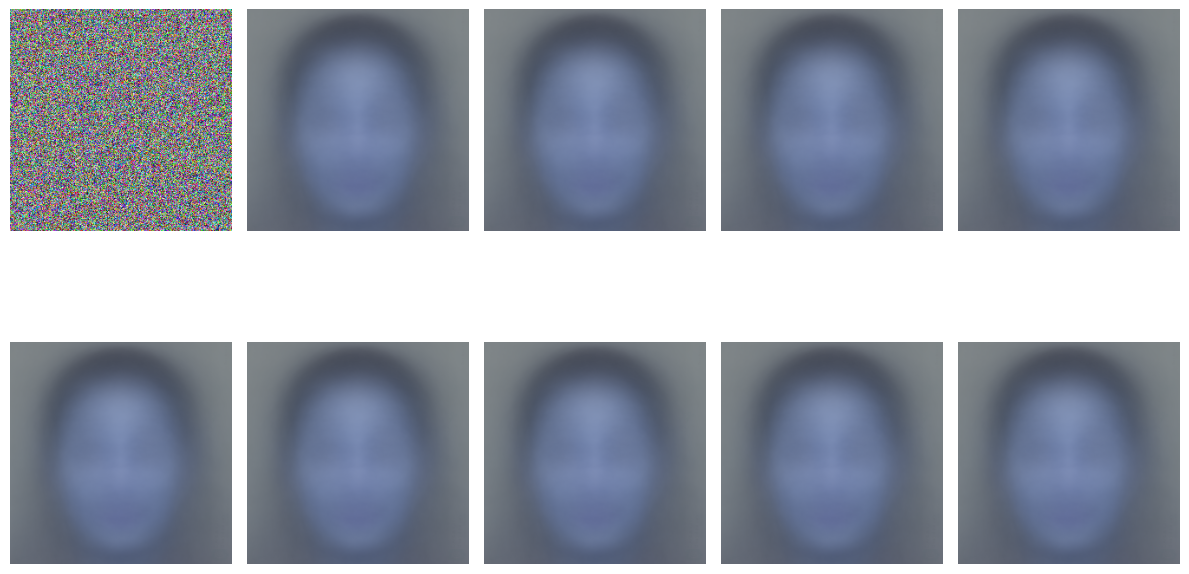

In [17]:
import matplotlib.pyplot as plt

# Function to visualize a grid of images
def plot_image_grid(images, num_cols=5):
    num_images = images.shape[0]
    num_rows = (num_images - 1) // num_cols + 1
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize generated human images
num_steps = generated_human_images.shape[0]
plot_image_grid(generated_human_images)  # Show every 10th image

In [20]:
# Function to visualize a grid of images and save them to disk
def save_image_grid(images, output_dir, prefix, num_cols=5, format='png'):
    num_images = images.shape[0]
    num_rows = (num_images - 1) // num_cols + 1
    for i in range(num_images):
        plt.imshow(images[i])
        plt.axis('off')
        plt.savefig(f'{output_dir}/{prefix}_{i}.{format}', bbox_inches='tight', pad_inches=0)
        plt.clf()

# Define the output directory where the generated images will be saved
output_dir = '/content/drive/MyDrive/LSTM_generated_images'

# Ensure the output directory exists, create it if necessary
import os
os.makedirs(output_dir, exist_ok=True)

# Save generated human images
num_steps = generated_human_images.shape[0]
save_image_grid(generated_human_images, output_dir, 'gen_img', num_cols=5, format='png')


<Figure size 640x480 with 0 Axes>

#Build Model 2 : CNN+LSTM

In [21]:
from keras import backend as K

K.clear_session()

In [22]:
# Build CNN + LSTM model for image generation
def build_higher_capacity_model(input_shape):
    model = Sequential()

    # Additional Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Existing layers from the previous model
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Reshape((1, -1)))  # Reshape the flattened features to have a sequence length of 1

    # Additional LSTM layer
    model.add(LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(0.3))

    model.add(LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(0.3))

    # Additional Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(np.prod(input_shape), activation='sigmoid'))
    model.add(Reshape(input_shape))

    return model


In [23]:
cnnlstm_model = build_higher_capacity_model(input_shape)

cnnlstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0

In [24]:
# Compile the models
learning_rate = 0.0001
cnnlstm_model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate==learning_rate))

# Split data into training and validation sets
humans_train, humans_val = train_test_split(humans_data, test_size=0.2, random_state=42)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the models with validation data
num_epochs = 100
batch_size = 64

history = cnnlstm_model.fit(np.array(humans_train), np.array(humans_train),
                                  epochs=num_epochs, batch_size=batch_size,
                                  validation_data=(np.array(humans_val), np.array(humans_val)),
                                  callbacks=[early_stopping], verbose=1)

Epoch 1/100
42/42 [==============================] - 16s 123ms/step - loss: 0.2645 - val_loss: 0.2763
Epoch 2/100
42/42 [==============================] - 3s 72ms/step - loss: 0.2790 - val_loss: 0.2763
Epoch 3/100
42/42 [==============================] - 3s 66ms/step - loss: 0.2785 - val_loss: 0.2768
Epoch 4/100
42/42 [==============================] - 3s 68ms/step - loss: 0.2791 - val_loss: 0.2771
Epoch 5/100
42/42 [==============================] - 3s 66ms/step - loss: 0.2793 - val_loss: 0.2776
Epoch 6/100
42/42 [==============================] - 3s 68ms/step - loss: 0.2797 - val_loss: 0.2779
Epoch 7/100
42/42 [==============================] - 3s 66ms/step - loss: 0.2801 - val_loss: 0.2781
Epoch 8/100
42/42 [==============================] - 3s 68ms/step - loss: 0.2803 - val_loss: 0.2784
Epoch 9/100
42/42 [==============================] - 3s 67ms/step - loss: 0.2805 - val_loss: 0.2786
Epoch 10/100
42/42 [==============================] - 3s 67ms/step - loss: 0.2806 - val_loss: 0.27

#Generate Images

In [25]:
def generate_image1(model, seed_image, temperature=1.0):
    # Expand the seed image to have a sequence length of 1
    seed_image_seq = np.expand_dims(seed_image, axis=0)

    # Predict the next image in the sequence
    generated_image1 = model.predict(seed_image_seq)

    # Apply temperature scaling to control the output diversity
    generated_image1 = np.power(generated_image1, 1.0 / temperature)
    generated_image1 /= np.max(generated_image1)  # Normalize the output

    return generated_image1.squeeze()

# Generate images using the trained models
num_generated_images = 10
temperature = 0.8

# Generate images for humans LSTM model
seed_humans_image = humans_train[0]  # Use the first image from the training set as the seed

generated_humans_images1 = []
current_image = seed_humans_image

for _ in range(num_generated_images):
    # Generate a single image at a time using the current image as seed
    generated_image = generate_image1(cnnlstm_model, current_image, temperature=temperature)
    generated_humans_images1.append(generated_image)
    current_image = generated_image  # Update the current image for the next iteration

generated_humans_images1 = np.array(generated_humans_images1)

# Save the generated images
output_directory_humans = "/content/drive/MyDrive/cnnlstm_gen_img"


os.makedirs(output_directory_humans, exist_ok=True)

for i, image in enumerate(generated_humans_images1):
    output_path = os.path.join(output_directory_humans, f"generated_img_{i}.jpg")
    cv2.imwrite(output_path, (image * 255).astype(np.uint8))



1/1 [==============================] - 0s 21ms/step


#Build Model 3 : CNN+LSTM with hyperparameter tuning

In [26]:
def build_model3(input_shape):
    model = Sequential()

    # Additional Convolutional layers
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Existing layers from the previous model
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Reshape((1, -1)))  # Reshape the flattened features to have a sequence length of 1

    # Additional LSTM layer
    model.add(LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(0.4))

    model.add(LSTM(512, return_sequences=True, recurrent_initializer='glorot_uniform'))
    model.add(Dropout(0.4))

    # Additional Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(np.prod(input_shape), activation='sigmoid'))
    model.add(Reshape(input_shape))

    return model


In [27]:
model3 = build_model3(input_shape)

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        36896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)      

In [28]:
K.clear_session()

from keras.optimizers import Adam

# Compile the models with a smaller learning rate
learning_rate = 0.0001  # You can adjust this value as needed
model3.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

# Split data into training and validation sets
humans_train3, humans_val3 = train_test_split(humans_data, test_size=0.2, random_state=42)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the models with validation data
num_epochs = 100
batch_size = 32

history3 = model3.fit(np.array(humans_train3), np.array(humans_train3),
                                  epochs=num_epochs, batch_size=batch_size,
                                  validation_data=(np.array(humans_val3), np.array(humans_val3)),
                                  callbacks=[early_stopping], verbose=1)

Epoch 1/100
83/83 [==============================] - 9s 60ms/step - loss: 0.0876 - val_loss: 0.0839
Epoch 2/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0874 - val_loss: 0.0838
Epoch 3/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0832 - val_loss: 0.0767
Epoch 4/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0801 - val_loss: 0.0765
Epoch 5/100
83/83 [==============================] - 3s 41ms/step - loss: 0.0794 - val_loss: 0.0754
Epoch 6/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0769 - val_loss: 0.0692
Epoch 7/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0670 - val_loss: 0.0574
Epoch 8/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0597 - val_loss: 0.0555
Epoch 9/100
83/83 [==============================] - 3s 38ms/step - loss: 0.0576 - val_loss: 0.0557
Epoch 10/100
83/83 [==============================] - 3s 40ms/step - loss: 0.0562 - val_loss: 0.0530

#Generate Images

In [29]:
def generate_image3(model, seed_image, temperature=1.0):
    # Expand the seed image to have a sequence length of 1
    seed_image_seq = np.expand_dims(seed_image, axis=0)

    # Predict the next image in the sequence
    generated_image3 = model.predict(seed_image_seq)

    # Apply temperature scaling to control the output diversity
    generated_image3 = np.power(generated_image3, 1.0 / temperature)
    generated_image3 /= np.max(generated_image3)  # Normalize the output

    return generated_image3.squeeze()


# Generate images using the trained models
num_generated_images = 10
temperature = 0.5

# Generate images for humans LSTM model
seed_humans_image3 = humans_train3[0]  # Use the first image from the training set as the seed

generated_humans_images3 = []
current_image3 = seed_humans_image3

for _ in range(num_generated_images):
    # Generate a single image at a time using the current image as seed
    generated_image3 = generate_image3(model3, current_image3, temperature=temperature)
    generated_humans_images3.append(generated_image3)
    current_image = generated_image3  # Update the current image for the next iteration

generated_humans_images3 = np.array(generated_humans_images3)

# Save the generated images
output_directory_humans = "/content/drive/MyDrive/hyperparagenimg"


os.makedirs(output_directory_humans, exist_ok=True)

for i, image in enumerate(generated_humans_images3):
    output_path = os.path.join(output_directory_humans, f"generated_img_{i}.jpg")
    cv2.imwrite(output_path, (image * 255).astype(np.uint8))

1/1 [==============================] - 0s 22ms/step


#Build Model 4 : CNN+LSTM with hyperparameter tuning and Regularization

In [30]:
from keras.regularizers import l2
from keras import Model, Input

def build_model4(input_shape):
    inputs = Input(shape=input_shape)

    # Additional Convolutional layers
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    # Existing layers from the previous model
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Reshape((1, -1))(x)  # Reshape the flattened features to have a sequence length of 1

    # Additional LSTM layer with dropout and L2 regularization
    x = LSTM(256, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)  # Adding dropout with a rate of 0.4

    x = LSTM(512, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)  # Adding dropout with a rate of 0.4

    # Additional Dense layers with dropout and L2 regularization
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)  # Adding dropout with a rate of 0.4

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)  # Adding dropout with a rate of 0.4

    outputs = Dense(np.prod(input_shape), activation='sigmoid', kernel_regularizer=l2(0.01))(x)
    outputs = Reshape(input_shape)(outputs)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [31]:
model4 = build_model4(input_shape)

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 32)        36896 

In [32]:
K.clear_session()

# Compile the models with a smaller learning rate
learning_rate = 0.0001
model4.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

# Split data into training and validation sets
humans_train4, humans_val4 = train_test_split(humans_data, test_size=0.2, random_state=42)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the models with validation data
num_epochs = 250
batch_size = 32

humans_history = model4.fit(np.array(humans_train4), np.array(humans_train4),
                                  epochs=num_epochs, batch_size=batch_size,
                                  validation_data=(np.array(humans_val4), np.array(humans_val4)),
                                  callbacks=[early_stopping], verbose=1)

Epoch 1/250
83/83 [==============================] - 9s 68ms/step - loss: 22.3358 - val_loss: 13.3214
Epoch 2/250
83/83 [==============================] - 3s 41ms/step - loss: 9.6535 - val_loss: 6.9333
Epoch 3/250
83/83 [==============================] - 3s 41ms/step - loss: 5.5082 - val_loss: 4.3350
Epoch 4/250
83/83 [==============================] - 3s 41ms/step - loss: 3.5794 - val_loss: 2.9003
Epoch 5/250
83/83 [==============================] - 3s 42ms/step - loss: 2.4156 - val_loss: 1.9664
Epoch 6/250
83/83 [==============================] - 3s 41ms/step - loss: 1.6405 - val_loss: 1.3355
Epoch 7/250
83/83 [==============================] - 3s 42ms/step - loss: 1.1162 - val_loss: 0.9091
Epoch 8/250
83/83 [==============================] - 3s 41ms/step - loss: 0.7629 - val_loss: 0.6228
Epoch 9/250
83/83 [==============================] - 3s 41ms/step - loss: 0.5263 - val_loss: 0.4318
Epoch 10/250
83/83 [==============================] - 3s 41ms/step - loss: 0.3690 - val_loss: 0.30

#Generate Images

In [33]:
def generate_image4(model, seed_image, temperature=1.0):
    # Expand the seed image to have a sequence length of 1
    seed_image_seq4 = np.expand_dims(seed_image, axis=0)

    # Predict the next image in the sequence
    generated_image4 = model.predict(seed_image_seq4)

    # Apply temperature scaling to control the output diversity
    generated_image4 = np.power(generated_image4, 1.0 / temperature)
    generated_image4 /= np.max(generated_image4)  # Normalize the output

    return generated_image4.squeeze()


# Generate images using the trained models
num_generated_images = 15
temperature = 0.5

# Generate images for humans LSTM model
seed_humans_image4 = humans_train4[0]  # Use the first image from the training set as the seed

generated_humans_images4 = []
current_image4 = seed_humans_image4

for _ in range(num_generated_images):
    # Generate a single image at a time using the current image as seed
    generated_image4 = generate_image4(model4, current_image4, temperature=temperature)
    generated_humans_images4.append(generated_image4)
    current_image4 = generated_image4  # Update the current image for the next iteration

generated_humans_images4 = np.array(generated_humans_images4)

# Save the generated images
output_directory_humans = "/content/drive/MyDrive/regulgenimg"


os.makedirs(output_directory_humans, exist_ok=True)

for i, image in enumerate(generated_humans_images4):
    output_path = os.path.join(output_directory_humans, f"generated_img_{i}.jpg")
    cv2.imwrite(output_path, (image * 255).astype(np.uint8))


1/1 [==============================] - 0s 22ms/step


#Evaluation for model 1

In [36]:
from sklearn.metrics import mean_squared_error

# Reshape the real human images to match the generated images shape
real_human_images = humans_data.reshape(humans_data.shape[0], 256, 256, 3)

# Select a subset of real human images with the same number of generated images
num_generated_images = generated_human_images.shape[0]
real_human_images_subset = real_human_images[:num_generated_images]

# Flatten the images to 1D arrays before calculating the MSE
real_human_images_flat = real_human_images_subset.reshape(num_generated_images, -1)
generated_images_flat = generated_human_images.reshape(num_generated_images, -1)

# Calculate MSE between flattened generated and real human images
mse = mean_squared_error(real_human_images_flat, generated_images_flat)

print("Mean Squared Error (MSE):", mse)


Mean Squared Error (MSE): 0.07841174857567472


In [38]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Assuming you have the real human images in humans_data
# Reshape the real human images to match the generated images shape
real_human_images = humans_data.reshape(humans_data.shape[0], 256, 256, 3)

# Calculate SSIM between generated and real human images
ssim_values = []
for i in range(len(generated_human_images)):
    # SSIM expects images in the range [0, 1], so rescale them if needed
    generated_image_scaled = generated_human_images[i] / 255.0
    real_image_scaled = real_human_images[i] / 255.0

    # Calculate SSIM for the current pair of images
    ssim_value = ssim(generated_image_scaled, real_image_scaled, channel_axis=2)

    ssim_values.append(ssim_value)

# Calculate the average SSIM value
mean_ssim = np.mean(ssim_values)

print("Mean Structural Similarity Index (SSIM):", mean_ssim)


Mean Structural Similarity Index (SSIM): 0.9974979327595855


#Evaluation for model 2

In [41]:
# Reshape the real human images to match the generated images shape
real_human_images = humans_data.reshape(humans_data.shape[0], 256, 256, 3)

# Calculate MSE between flattened generated and real human images for the new model
num_generated_images = generated_humans_images1.shape[0]
real_human_images_subset = real_human_images[:num_generated_images]

# Flatten the real human images and the generated images
real_human_images_flat = real_human_images_subset.reshape(num_generated_images, -1)
generated_images_flat = generated_humans_images1.reshape(num_generated_images, -1)

# Calculate MSE between flattened generated and real human images
mse_cnnlstm = mean_squared_error(real_human_images_flat, generated_images_flat)

print("Mean Squared Error (MSE) for CNN + LSTM model:", mse_cnnlstm)


# Calculate SSIM between generated and real human images for the new model
ssim_values_cnnlstm = []
for i in range(len(generated_humans_images1)):
    # SSIM expects images in the range [0, 1], so rescale them if needed
    generated_image_scaled = generated_humans_images1[i] / 255.0
    real_image_scaled = real_human_images[i] / 255.0

    # Calculate SSIM for the current pair of images
    ssim_value = ssim(generated_image_scaled, real_image_scaled, channel_axis=2)

    ssim_values_cnnlstm.append(ssim_value)

# Calculate the average SSIM value
mean_ssim_cnnlstm = np.mean(ssim_values_cnnlstm)

print("Mean Structural Similarity Index (SSIM) for CNN + LSTM model:", mean_ssim_cnnlstm)


Mean Squared Error (MSE) for CNN + LSTM model: 0.21994792
Mean Structural Similarity Index (SSIM) for CNN + LSTM model: 0.9950638


#Evaluation for model 3

In [42]:
# Assuming you have the real human images in humans_data
# Reshape the real human images to match the generated images shape
real_human_images = humans_data.reshape(humans_data.shape[0], 256, 256, 3)

# Calculate MSE between flattened generated and real human images for model3
num_generated_images = generated_humans_images3.shape[0]
real_human_images_subset = real_human_images[:num_generated_images]

# Flatten the real human images and the generated images
real_human_images_flat = real_human_images_subset.reshape(num_generated_images, -1)
generated_images_flat = generated_humans_images3.reshape(num_generated_images, -1)

# Calculate MSE between flattened generated and real human images for model3
mse_model3 = mean_squared_error(real_human_images_flat, generated_images_flat)

print("Mean Squared Error (MSE) for model3:", mse_model3)

# Calculate SSIM between generated and real human images for model3
ssim_values_model3 = []
for i in range(len(generated_humans_images3)):
    # SSIM expects images in the range [0, 1], so rescale them if needed
    generated_image_scaled = generated_humans_images3[i] / 255.0
    real_image_scaled = real_human_images[i] / 255.0

    # Calculate SSIM for the current pair of images
    ssim_value = ssim(generated_image_scaled, real_image_scaled, channel_axis=2)

    ssim_values_model3.append(ssim_value)

# Calculate the average SSIM value for model3
mean_ssim_model3 = np.mean(ssim_values_model3)

print("Mean Structural Similarity Index (SSIM) for model3:", mean_ssim_model3)


Mean Squared Error (MSE) for model3: 0.09115288
Mean Structural Similarity Index (SSIM) for model3: 0.99677527


In [43]:
# Assuming you have the real human images in humans_data
# Reshape the real human images to match the generated images shape
real_human_images = humans_data.reshape(humans_data.shape[0], 256, 256, 3)

# Calculate MSE between flattened generated and real human images for model4
num_generated_images = generated_humans_images4.shape[0]
real_human_images_subset = real_human_images[:num_generated_images]

# Flatten the real human images and the generated images
real_human_images_flat = real_human_images_subset.reshape(num_generated_images, -1)
generated_images_flat = generated_humans_images4.reshape(num_generated_images, -1)

# Calculate MSE between flattened generated and real human images for model4
mse_model4 = mean_squared_error(real_human_images_flat, generated_images_flat)

print("Mean Squared Error (MSE) for model4:", mse_model4)

# Calculate SSIM between generated and real human images for model4
ssim_values_model4 = []
for i in range(len(generated_humans_images4)):
    # SSIM expects images in the range [0, 1], so rescale them if needed
    generated_image_scaled = generated_humans_images4[i] / 255.0
    real_image_scaled = real_human_images[i] / 255.0

    # Calculate SSIM for the current pair of images
    ssim_value = ssim(generated_image_scaled, real_image_scaled, channel_axis=2)

    ssim_values_model4.append(ssim_value)

# Calculate the average SSIM value for model4
mean_ssim_model4 = np.mean(ssim_values_model4)

print("Mean Structural Similarity Index (SSIM) for model4:", mean_ssim_model4)


Mean Squared Error (MSE) for model4: 0.06630329
Mean Structural Similarity Index (SSIM) for model4: 0.99767333


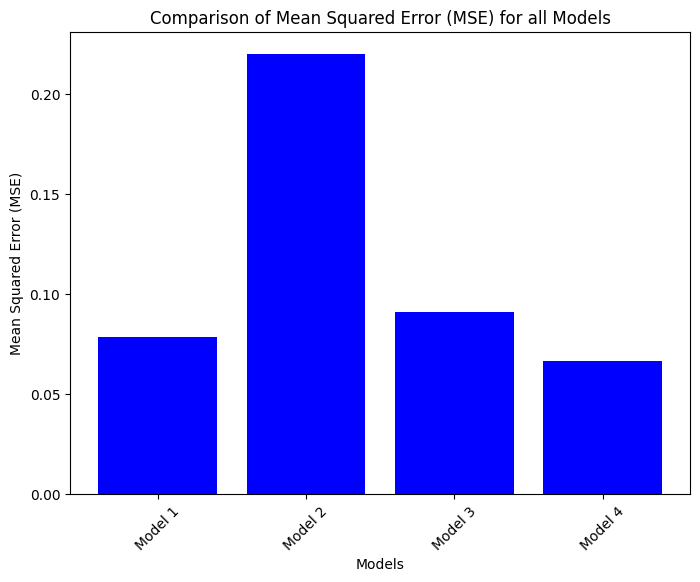

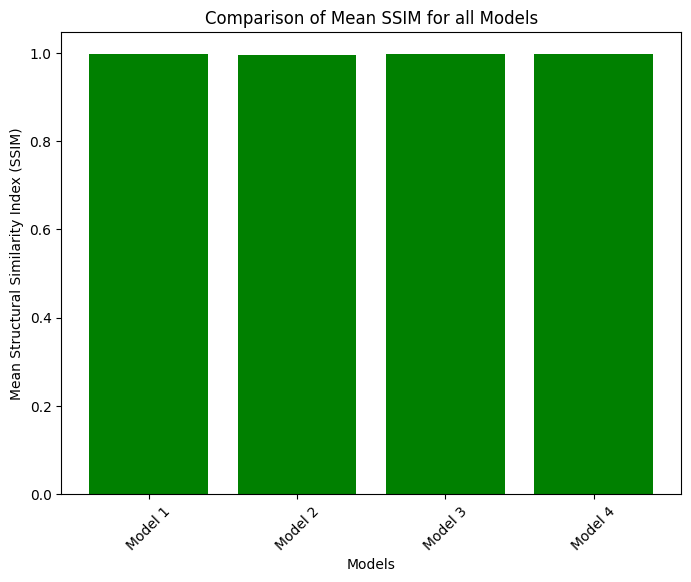

In [45]:
import matplotlib.pyplot as plt

# Evaluation metrics for all models
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
mse_values = [mse, mse_cnnlstm, mse_model3, mse_model4]
ssim_values = [mean_ssim, mean_ssim_cnnlstm, mean_ssim_model3, mean_ssim_model4]

# Plotting the bar chart for MSE values
plt.figure(figsize=(8, 6))
plt.bar(models, mse_values, color='blue')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Mean Squared Error (MSE) for all Models')
plt.xticks(rotation=45)
plt.show()

# Plotting the bar chart for SSIM values
plt.figure(figsize=(8, 6))
plt.bar(models, ssim_values, color='green')
plt.xlabel('Models')
plt.ylabel('Mean Structural Similarity Index (SSIM)')
plt.title('Comparison of Mean SSIM for all Models')
plt.xticks(rotation=45)
plt.show()
